In [2]:
import numpy as np
import matplotlib.pyplot as plt
import exogas.radial_simulation as rsimulation
import time #import gmtime, strftime
#import general_functions as gf 
from exogas.constants import *

%matplotlib inline

We want to define first our system parameters. If not these will be set to default values for a 2 Msun star with a belt at 100 au, a constant fractional luminosity of $10^{-3}$ and an $\alpha$ viscosity of $10^{-3}$

In [3]:
#### system parameters

Mstar=1.5
Lstar=6.2 # if not mandatory, it will be set according to the luminosity following a simple MS relation.
fco=0.1 # mass fraction of CO in planetesimals
rbelt=120.0 #  au
width=60.  # au, FWHM
tf=1.0e7   # yr final time of the simulation
alpha=1.0e-4 # alpha viscosity parameter
fir=5.e-3    # fractional luminosity at t=tf
fion=0.0    # fraction of carbon that is ionised
fCI=1.-fion
tcoll=1.0e6 # collisional timescale. Set to None or negative to consider a constant fir and CO input rate
Ntout=100 


You can set the CO mass input rate either directly with the parameter MdotCO. If you don't indicate MdotCO, it will be calculated automatically based on the fractional luminosity of the belt (fir) and CO mass fraction (fco). Note that if tcoll is $>0$ then MdotCO represents the CO mass input rate at t=tf. MdotCO(t) is then
$$ \dot{M}_{\rm CO} (t) = \dot{M}_{\rm CO} (t_{\rm f}) \left(\frac{1+t/t_{\rm f}}{1+t/t_{\rm coll}} \right)^2$$

Below we initialize our simulation object

In [4]:
MdotCO=1.0e-7 # Mearth/Myr

#### INITIALIZE SIMULATION
sim=rsimulation.simulation(ts_out=np.logspace(3, np.log10(tf), Ntout), 
                          Mstar=Mstar,
                          Lstar=Lstar,
                          fco=fco,
                          rbelt=rbelt,
                          width=width,
                          alpha=alpha,
                          fir=fir,
                          fion=fion,
                          tcoll=tcoll,
                          # MdotCO=MdotCO # This line is optional depending on if you want to set MdotCO to a specific value or not  
                         )


varying CO input rate based on final fractional luminosity and tcoll given by the user
Rmax = 3000.0 au
Nr = 105
Nt simulation=166667
simulation timestep = 60.0 yr
viscous timescale to cross one radial bin = 134691.8 yr
tvis = 8.0e+08 yr
Mdot CO at t=0 is 4.0e-05 Mearth/yr
Mdot CO at t=tf is 3.3e-07 Mearth/yr


In [5]:
#### RUN SIMULATION
print( 'Running simulation...')
T1=time.gmtime()
sim.viscous_evolution()
T2=time.gmtime()
print('Execution time in sec: ',time.mktime(T2)-time.mktime(T1)) 

Running simulation...
simulation finished
Execution time in sec:  40.0


Now our results are stored in sim.Sigma_g that is a numpy array of dimensions (2xNrxNt). The CO surface density at t=0 is given by

sim.Sigma_g[0,:,0] (if ts_out[0]=0 or sim.Sigma0[0,:] if not)




while the carbon surface density at t=tf is

sim.Sigma_g[0,:,-1]

The radial grid is given by sim.grid.rs and the temporal grid is given by sim.ts


In [6]:
### CALCULATE TOTAL MASS evolution

rmax_mtot=sim.grid.rmax # maximum radius up to which calculate the total gas mass
mask_mtot=sim.grid.rs<=rmax_mtot
MCOs=np.sum(sim.Sigma_g[0,mask_mtot,:].T*sim.grid.hs[mask_mtot]*sim.grid.rs[mask_mtot]*2.0*np.pi, axis=1)
MC1s=np.sum(sim.Sigma_g[1,mask_mtot,:].T*sim.grid.hs[mask_mtot]*sim.grid.rs[mask_mtot]*2.0*np.pi, axis=1)

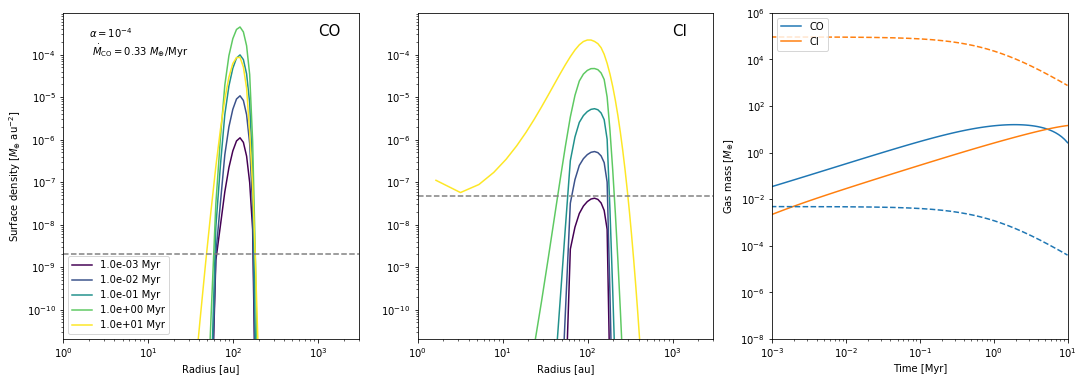

In [7]:
## let's plot now the surface density evolution

### critical surface densities
sigma_C1c=(1./sigma_c1)*m_c1/Mearth*au_cm**2.0 # mearth/au2
sigma_COc=(1./sigma_co)*m_co/Mearth*au_cm**2.0 # mearth/au2

### EPOCHS TO PLOT
ts_plot=np.logspace(3, int(np.log10(tf)), int(np.log10(tf))-3+1) # this will generate epochs from 1000 yr to tf in factors of 10

fig=plt.figure(figsize=(18,6))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
ax3=fig.add_subplot(133)

#### plottingg surface densities
for i, ti in enumerate(ts_plot):
    it=0
    ### find epoch in time grid
    for k in range(len(sim.ts)):
        if sim.ts[k]>=ti:
            it=k
            break

    cmap=plt.get_cmap('viridis')
    x=i*1./(len(ts_plot)-1)
    colori=cmap(x)
#
    ax1.plot(sim.grid.rs, sim.Sigma_g[0,:,it], color=colori, label='%1.1e'%(ts_plot[i]/1.0e6)+' Myr')
    ax2.plot(sim.grid.rs, sim.Sigma_g[1,:,it]*fCI, color=colori, label='%1.1e'%(ts_plot[i]/1.0e6)+' Myr')

### draw critical surface densities
ax1.axhline(sigma_COc, color='grey', ls='dashed')
ax2.axhline(sigma_C1c, color='grey', ls='dashed')

# maximum and minimum surface densities to plot
ymax=max( np.max(sim.Sigma_g[0,:,:]), np.max(sim.Sigma_g[1,:,:]), sigma_C1c)*2.0
ymin=min( sim.Sigma_g[0,sim.ibelt,it], sigma_COc)/100.0
for axi in [ax1, ax2]:
    axi.set_xlim(1.0, 3.0e3)
    axi.set_ylim(ymin, ymax)
    axi.set_xscale('log')
    axi.set_yscale('log')
    axi.set_xlabel('Radius [au]')
ax1.legend(frameon=True, loc=3)
ax1.set_ylabel(r'Surface density [$M_{\oplus}$ au$^{-2}$]')

## some labels
ytext1=ymax * 10** ( -0.13 *(np.log10(ymax)-np.log10(ymin))  )
ytext2=ymax * 10** ( -0.07 *(np.log10(ymax)-np.log10(ymin))  )
ax1.text(2.0, ytext1, r'$\alpha=10^{%1.0f}$'%np.log10(sim.alpha)+'\n $\dot{M}_\mathrm{CO}=%1.2f$'%(sim.MdotCO[-1]*1.0e6)+r' $M_{\oplus}$/Myr')
ax1.text(1.0e3, ytext2, 'CO',fontsize=15)
ax2.text(1.0e3, ytext2, 'CI',fontsize=15)

#### plotting masses

ax3.plot(sim.ts/1.0e6, MCOs, color='C0', label='CO')
ax3.plot(sim.ts/1.0e6, MC1s*fCI, color='C1', label='CI')

MCO_st=sim.MdotCO*120.0 # solution in quasy steady state if CO is unshielded. Note that sim.dotCO is larger than sim.ts because it does not skip any epochs. Its corresponding time array is sim.ts_sim
MC1_st=sim.MdotCO*m_c1/m_co * (2.*sim.rbelt / (3.*sim.nus_au2_yr[0]*(1./sim.grid.rs[0])))*(1.+2.*(rmax_mtot/sim.rbelt)**0.5-1.0) # From integrating Metzeger equations
ax3.plot(sim.ts_sim/1.0e6, MCO_st, color='C0', ls='dashed')
ax3.plot(sim.ts_sim/1.0e6, MC1_st, color='C1', ls='dashed')
ax3.set_ylabel(r'Gas mass [$M_{\oplus}$]')
ax3.set_xlabel(r'Time [Myr]')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(ts_plot[0]/1.0e6, ts_plot[-1]/1.0e6)
ax3.set_ylim(1.0e-8, 1.0e6)
ax3.legend(frameon=True, loc=2)


The ploting routine above can be shortened by using sim.plot_panels that returns a figure

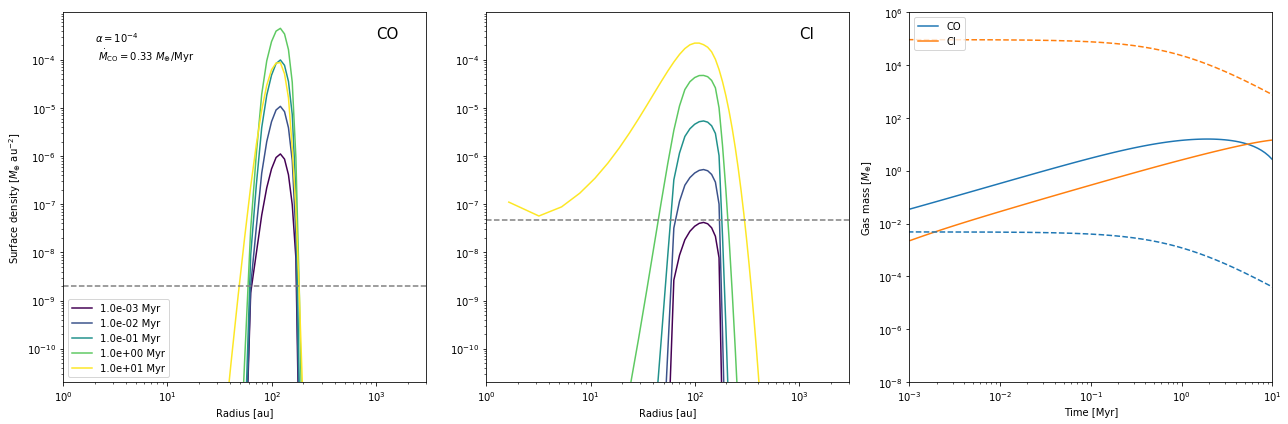

In [8]:
### EPOCHS TO PLOT
ts_plot=np.logspace(3, int(np.log10(tf)), int(np.log10(tf))-3+1) # this will generate epochs from 1000 yr to tf in factors of 10
fig=sim.plot_panels(ts_plot)

# Customization

You can customize a few things depending on your needs. For example, you can increase the resolution with the parameter resolution, which sets the fractional width of the radial bin at the belt location. So for example, a resolution of 0.1 for a belt at 100 au, will have a radial bin at 100 au with a width of 10 au. By default the resolution is set to 0.1.

You can also include a process to remove carbon based on the amount of dust. This is done by settin the parameter carbon_capture to True when you initialize the simulation. You can specify the probability of carbon atoms being captured by grains after a collision with the parameter pcapture. The carbon capture surface density rate is set by

$$ \dot{\Sigma}_{\rm C}^{-} = - P_{\rm capture} \frac{\Sigma_{\rm C} \Omega_{\rm K} f_{\rm IR} r}{\sigma_{\rm belt}\sqrt{2\pi}} \exp\left[ - \frac{(r-r_{\rm belt})^2}{2\sigma_{\rm belt}^2} \right] $$ 


You can also change the initial surface density to whatever you want. By default this is set to a power law with an exponential cut-off radius of 50au. 

$$ 10^{-50}  \left(\frac{r}{r_c}\right)^{-1}\exp\left[-\frac{r}{r_c}\right]\ M_{\oplus}\ {\rm au}^{-2}$$

Moreover, you can switch off the CO photodissociation or diffusion with the parameters "photodissociation" and "diffusion".

In the example below I will change the resolution, include carbon capture, increase the viscosity, set tcoll to -1 so the CO input rate is constant, set the CO input rate manually, and define my own initial surface density.


In [ ]:
#### INITIALIZE SIMULATION


sim=rsimulation.simulation(ts_out=np.logspace(3, np.log10(tf), Ntout), 
                          Mstar=Mstar,
                          Lstar=Lstar,
                          fco=fco,
                          rbelt=rbelt,
                          width=width,
                          alpha=1.0e-1,
                          fir=fir,
                          fion=fion,
                          tcoll=-1.,
                          carbon_capture=True,
                          pcapture=0.5,
                          resolution=0.05,
                          MdotCO=1.0e-6,
                         )
sim.Sigma0[:,:] = 1.0e-10 * (sim.grid.rs/sim.rbelt)**(-1) * np.exp(- sim.grid.rs/sim.rbelt)
#### RUN SIMULATION
print( 'Running simulation...')
T1=time.gmtime()
sim.viscous_evolution()
T2=time.gmtime()
print('Execution time in sec: ',time.mktime(T2)-time.mktime(T1)) 


fixed CO input rate based on Mdot given by the user
Rmax = 4836.4 au
Nr = 260
Nt simulation=272627
simulation timestep = 36.7 yr
viscous timescale to cross one radial bin = 36.7 yr
tvis = 8.0e+05 yr
Mdot CO at t=0 is 1.0e-06 Mearth/yr
Mdot CO at t=tf is 1.0e-06 Mearth/yr
Running simulation...


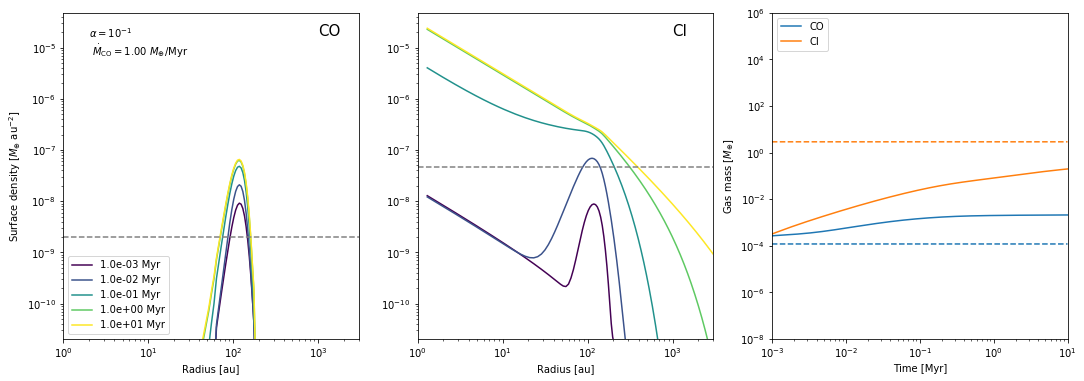

In [12]:
### EPOCHS TO PLOT
ts_plot=np.logspace(3, int(np.log10(tf)), int(np.log10(tf))-3+1) # this will generate epochs from 1000 yr to tf in factors of 10
fig=sim.plot_panels(ts_plot)

Now, let's include CO reformation with a probability "preform" to form a CO molecule for every carbon atom that is captured.

In [17]:
sim=rsimulation.simulation(ts_out=np.logspace(3, np.log10(tf), Ntout), 
                          Mstar=Mstar,
                          Lstar=Lstar,
                          fco=fco,
                          rbelt=rbelt,
                          width=width,
                          alpha=1.0e-3,
                          fir=fir,
                          fion=fion,
                          tcoll=-1.,
                          carbon_capture=True,
                          pcapture=0.5,
                          resolution=0.05,
                          #MdotCO=1.0e-6,
                          co_reformation=True,
                          preform=1.,
                         )


#### RUN SIMULATION
print( 'Running simulation...')
T1=time.gmtime()
sim.viscous_evolution()
T2=time.gmtime()
print('Execution time in sec: ',time.mktime(T2)-time.mktime(T1)) 



fixed CO input rate based on constant fractional luminosity
Rmax = 3000.0 au
Nr = 217
Nt simulation=166667
simulation timestep = 60.0 yr
viscous timescale to cross one radial bin = 3245.2 yr
tvis = 8.0e+07 yr
Mdot CO at t=0 is 3.3e-07 Mearth/yr
Mdot CO at t=tf is 3.3e-07 Mearth/yr
Running simulation...
Nt output=16668
simulation finished
Execution time in sec:  49.0


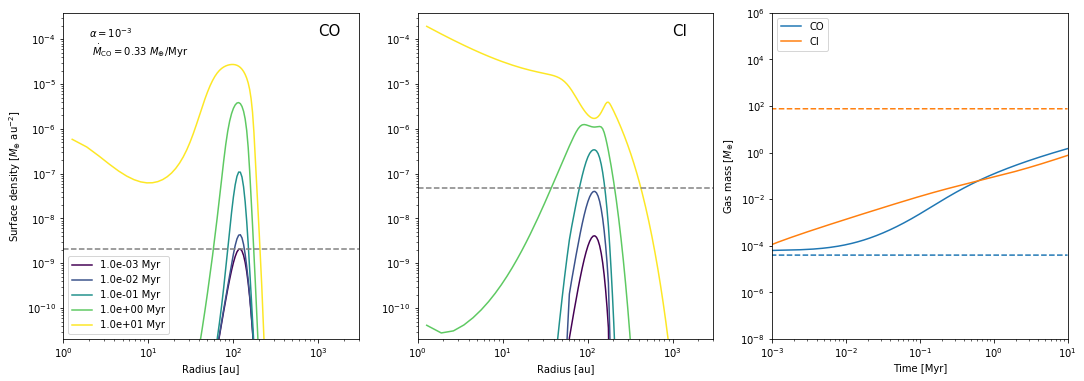

In [19]:
### EPOCHS TO PLOT
ts_plot=np.logspace(3, int(np.log10(tf)), int(np.log10(tf))-3+1) # this will generate epochs from 1000 yr to tf in factors of 10
fig=sim.plot_panels(ts_plot)